In [142]:
from collections import OrderedDict
from copy import deepcopy

import numpy as np
import pandas as pd
import tqdm
import eli5
from eli5.sklearn import PermutationImportance
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn import preprocessing
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.models import Input, Model
from keras.optimizers import Adam
from keras.activations import relu, sigmoid, tanh, selu
from keras.losses import binary_crossentropy
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
import seaborn as sns

In [16]:
# file_name = '/home/aga/Fizyka/licencjat/htt_features_test.pkl'
file_name = '/home/tultul/aga/htt_features_test.pkl'

In [17]:
def preprocess(file_name, enable_data=True, enable_dicriminators=True, mask_columns=[]):
    legs, jets, global_params, properties = pd.read_pickle(file_name)
    properties = OrderedDict(sorted(properties.items(), key=lambda t: t[0]))

    #     print("no of legs: ", len(legs))
    #     print("no of jets: ", len(jets))
    #     print("global params: ", global_params.keys())
    #     print("object properties:", properties.keys())

    sampleType = np.array(global_params["sampleType"])
    sampleType = np.reshape(sampleType, (-1, 1))
    features = np.array(list(properties.values()))
    features = np.transpose(features)
    feature_names = list(properties.keys())

    # Redefine DPF output to be 1 for signal
    discName = "leg_2_DPFTau_2016_v1tauVSall"
    DPF_index = feature_names.index(discName)
    features[:, DPF_index] *= -1
    features[:, DPF_index] += 1
    indexes = features[:, DPF_index] > 1
    features[indexes, DPF_index] = 0.0
    # Filter features to be usedfor training
    column_mask = np.full(features.shape[1], enable_data)
    oldMVA_discriminators = [
        "leg_2_byIsolationMVArun2v1DBnewDMwLTraw2017v2",
        "leg_2_DPFTau_2016_v1tauVSall",
        "leg_2_deepTau2017v1tauVSall",
        "leg_2_deepTau2017v1tauVSjet",
    ]
    for discName in oldMVA_discriminators:
        index = feature_names.index(discName)
        column_mask[index] = enable_dicriminators
    
    for col_name in mask_columns:
        index = feature_names.index(col_name)
        column_mask[index] = False
        
    features = features[:, column_mask]
    not_shuffled_features = deepcopy(features)
    not_shuffled_labels = deepcopy(sampleType)

    features = np.hstack((sampleType, features))
    np.random.shuffle(features)

    labels = features[:, 0]
    features = features[:, 1:]

    print("Input data shape:", features.shape)
    print("Number of positive examples:", (labels > 0.5).sum())
    print("Number of negative examples:", (labels < 0.5).sum())

    assert features.shape[0] == labels.shape[0]

    tmp = np.array(feature_names)
    tmp = tmp[column_mask]
    feature_names = list(tmp)
    return features, not_shuffled_features, labels, not_shuffled_labels, feature_names

In [175]:
class ModelWrapper:
    def __init__(self, **params):
        self.deep = params['deep']
        self.width = params['width']
        self.activation = params['activation']
        self.batch_size = params['batch_size']
        self.lr = params['lr']
        self.batch_norm = params['batch_norm']
        self.scheduler = params['scheduler']
        self.epochs = params['epochs']
        self.dropout = params['dropout']
    
    def _compile_model(self):
        layers = []
        for i in range(self.deep):
            layers.append(Dense(self.width, activation=self.activation))
            if self.batch_norm and i < self.deep - 1:
                layers.append(BatchNormalization())
            layers.append(Dropout(self.dropout))
        layers.append(Dense(1, activation=sigmoid))
        
        input_dense = Input((self.X_shape[1],))
        output = input_dense
        for l in layers:
            output = l(output)
        model = Model(inputs=[input_dense], outputs=output)
        model.compile(optimizer=Adam(lr=self.lr, clipvalue=3.0), loss=binary_crossentropy)
        self.model = model
    
    def get_params(self, deep):
        return {
            'deep': self.deep,
            'width': self.width,
            'activation': self.activation,
            'batch_size': self.batch_size,
            'lr': self.lr,
            'batch_norm': self.batch_norm,
            'epochs': self.epochs,
            'scheduler': self.scheduler,
            'dropout': self.dropout,
        }
    
    def set_params(self, **params):
        self.deep = params['deep']
        self.width = params['width']
        self.activation = params['activation']
        self.batch_size = params['batch_size']
        self.lr = params['lr']
        self.batch_norm = params['batch_norm']
        self.scheduler = params['scheduler']
        self.epochs = params['epochs']
        self.dropout = params['dropout']
    
    def fit(self, X, y):
        self.X_shape = X.shape
        self._compile_model()
        self.model.fit(X, y, batch_size=self.batch_size, validation_split=0.2,
                       epochs=self.epochs, callbacks=self.scheduler, verbose=0)
    
    def predict(self, X):
        return self.model.predict(X)

In [171]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.00001)

param_dist = {
    'deep': [1, 2, 3, 4, 5],
    'width': [32, 64, 128, 256, 512],
    'activation': [relu, sigmoid, tanh, selu],
    'batch_size': [32, 64, 128, 256],
    'lr': [0.0001, 0.0005, 0.001, 0.005, 0.01],
    'batch_norm': [True, False],
    'epochs': [2, 4, 6, 8],
    'scheduler': [[reduce_lr], []],
    'dropout': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
}

def scorer(estimator, X, y):
    pred = estimator.predict(X)
    return roc_auc_score(y, pred)

In [193]:
all_possibilities = []
for d in param_dist['deep']:
    for w in param_dist['width']:
        for a in param_dist['activation']:
            for bs in param_dist['batch_size']:
                for lr in param_dist['lr']:
                    for bn in param_dist['batch_norm']:
                        for e in param_dist['epochs']:
                            for s in param_dist['scheduler']:
                                for do in param_dist['dropout']:
                                    param = {
                                        'deep': d,
                                        'width': w,
                                        'activation': a,
                                        'batch_size': bs,
                                        'lr': lr,
                                        'batch_norm': bn,
                                        'epochs': e,
                                        'scheduler': s,
                                        'dropout': do,
                                    }
                                    all_possibilities.append(param)

In [185]:
features, not_shuffled_features, labels, not_shuffled_labels, feature_names = preprocess(file_name, True, True)

Input data shape: (345390, 23)
Number of positive examples: 35260
Number of negative examples: 310130


In [186]:
model = ModelWrapper(deep=1, width=32, activation=relu, batch_size=32, 
                     lr=0.001, batch_norm=False, epochs=2, scheduler=[], dropout=0.1)
# model.fit(features, labels)

In [196]:
remaining_possibilities = deepcopy(all_possibilities)

In [205]:
len(remaining_possibilities)

191861

In [ ]:
n_iter=1000
param_list = []
scores = []


for i in range(n_iter):
    params_id = np.random.randint(0, len(remaining_possibilities))
    params = remaining_possibilities.pop(params_id)
    model.set_params(**params)
    cv_scores = cross_val_score(model, features, labels, cv=3, scoring=scorer, n_jobs=5)
    param_list.append(params)
    scores.append(cv_scores)
    with open('params.txt', 'a') as file:
        file.write(str(params))
        file.write('\n')
        
    with open('scores.txt', 'a') as file:
        file.write(str(cv_scores))
        file.write('\n')

In [209]:
scores_max = np.max(scores, axis=1)

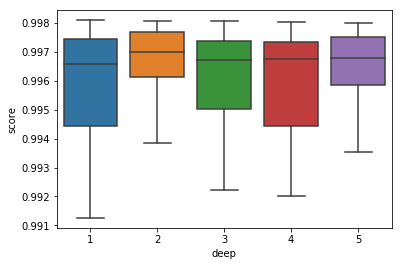

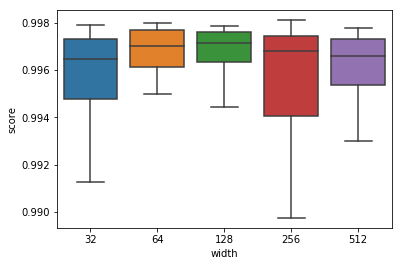

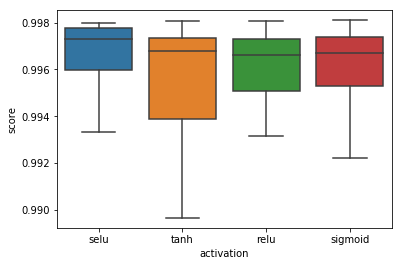

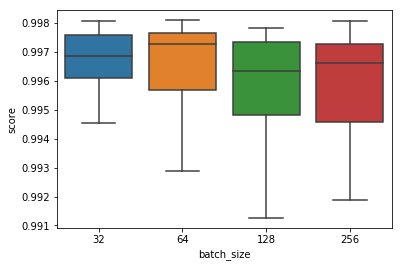

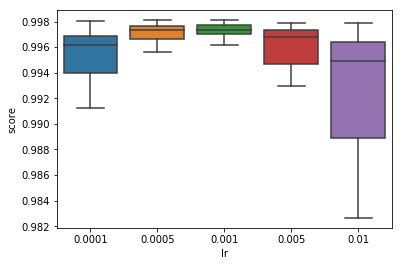

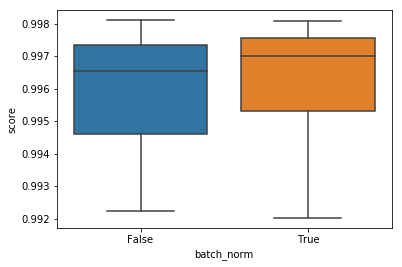

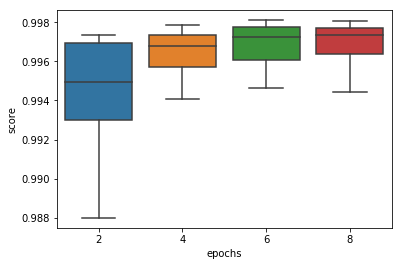

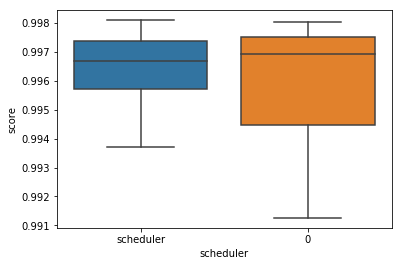

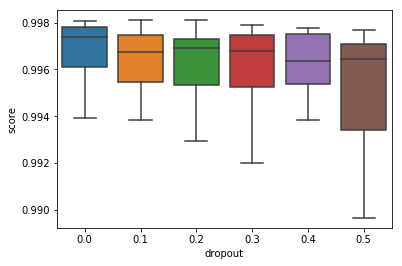

In [213]:
for col in param_dist.keys():
    df = pd.DataFrame(columns=['score', col])
    df['score'] = deepcopy(scores_max)
    df[col] = [param[col] for param in param_list]

    df = df.loc[df['score'] > 0.8, :]
    means = []
    maxes = []
    val_names = deepcopy(param_dist[col])
#     for val in val_names:
#         means.append(np.mean(df.loc[df[col] == val, 'score']))
#         maxes.append(np.max(df.loc[df[col] == val, 'score'])) 
    if col == 'scheduler':
        df[col] = ['0' if val == [] else 'scheduler' for val in df[col]]
        val_names = ['0' if val == [] else 'scheduler' for val in val_names]            
    else:
        if str(df.dtypes[col]) == 'object':
            df[col] = [str(val.__name__) for val in df[col]]
            val_names = [str(val.__name__) for val in val_names]
    sns.boxplot(df[col], df['score'], showfliers=False)
    plt.xlabel(col)
    plt.ylabel('score')
    plt.show()

In [58]:
best_params = param_list[np.argmax(scores_max)]

In [62]:
best_params

{'deep': 1,
 'width': 256,
 'activation': <function keras.activations.tanh(x)>,
 'batch_size': 32,
 'lr': 0.0001,
 'batch_norm': True,
 'epochs': 8,
 'scheduler': []}

In [224]:
# wybrane z wykresów
# best_params = {
#     'deep': 2,
#     'width': 128,
#     'activation': selu,
#     'batch_size': 64,
#     'lr': 0.001,
#     'batch_norm': True,
#     'epochs': 8,
#     'scheduler': [],
#     'dropout': 0.0,
# }

In [229]:
# z RandomSearcha sklearnowego
best_params = {
    'width': 256,
    'scheduler': [reduce_lr],
    'lr': 0.0005,
    'epochs': 6,
    'deep': 2,
    'batch_size': 256,
    'batch_norm': True,
    'activation': sigmoid,
    'dropout': 0.0,
}

In [219]:
# z mojego random searcha
# best_params = {
#     'deep': 1,
#     'width': 256,
#     'activation': sigmoid,
#     'batch_size': 64,
#     'lr': 0.0005,
#     'batch_norm': False,
#     'epochs': 6,
#     'scheduler': [reduce_lr],
#     'dropout': 0.2
# }

In [230]:
model.set_params(**best_params)

In [231]:
X_train, X_test, y_train, y_test = train_test_split(features, labels)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(roc_auc_score(y_test, preds))

0.9981620907783114


In [232]:
preds_not_shuffled = model.predict(not_shuffled_features)

In [233]:
np.save('preds_best_model', preds_not_shuffled)

In [27]:
results.best_params_

{'width': 256,
 'scheduler': [<keras.callbacks.ReduceLROnPlateau at 0x7f653416fef0>],
 'lr': 0.0005,
 'epochs': 6,
 'deep': 2,
 'batch_size': 256,
 'batch_norm': True,
 'activation': <function keras.activations.sigmoid(x)>}

In [28]:
results.best_score_

0.998044218432433